# Introduction
This notebook walks through the fiducial registration process for just a single US/MPM image pair, and using the functions transferred to the multicscale-imaging package.

In [1]:
# Import basic moduless
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [2]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.LINK_system.coordinate as coord
import multiscale.itk.transform as tran
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.microscopy.ome as ome

In [3]:
fiducial_dir = Path(r'F:\Research\LINK\Eye images\Fiducial')

mpm_tile_path = Path(fiducial_dir, r'MPM settings.ome.tif')
mpm_path = Path(fiducial_dir, r'MPM Fiducial_down4x.tif')

us_path = Path(fiducial_dir, r'Fiducial Z15891_Run-1.tif')
us_pl_path = Path(fiducial_dir, 'Fiducial Z15891.pos')
us_param_path = Path(fiducial_dir, r'Fiducial Z15891_Run-1_Settings.mat')
us_height = 15891
dynamic_range = 50

Open the images

In [4]:
mpm_image = coord.open_microscopy(mpm_path, mpm_tile_path, downsample_factor=4)

In [15]:
us_spacing = [36.00, 36.00, 36.00]
us_image = coord.open_us(us_path, us_pl_path, us_param_path, us_spacing, us_height, dynamic_range)

Acquire similar points between images

<IPython.core.display.Javascript object>


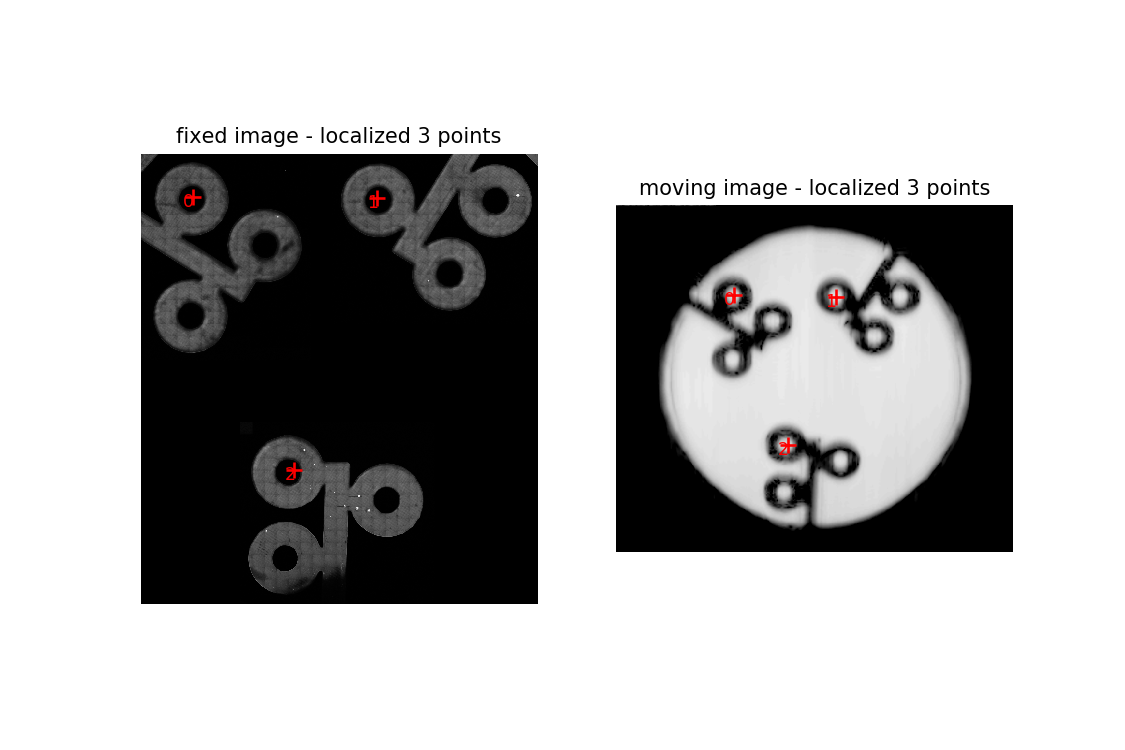

In [16]:
points = iplt.RegistrationPointDataAcquisition(mpm_image, us_image)

In [17]:
fixed_points, moving_points = points.get_points_flat()

Register the images

In [18]:
initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points, moving_points)
final_transform, metric, stop = reg.register(mpm_image, us_image, initial_transform=initial_transform)
final_params = final_transform.GetParameters()

In [19]:
centroid, labeled_img = coord.calculate_centroid(us_image[:, :, 40:120], radius=True, output_label_img=True)

Threshold used: 33.411582946777344


In [ ]:
iplt.MultiImageDisplay([sitk.LabelOverlay(us_image[:, :, 40:120], labeled_img)])

In [20]:
fiducial_bottom = np.mean(centroid)

z_translation = fiducial_bottom - (mpm_image.GetOrigin()[2])

In [21]:
coordinate_transform = np.array(final_params)
coordinate_transform[5] = z_translation
print('Final coordinate transform: {}'.format(coordinate_transform))

Final coordinate transform: [ 3.97930295e-03 -1.26074563e-03  3.63082910e-04 -3.24267883e+03
  5.44300907e+03  2.40080912e+04]


In [22]:
# Save the results
coordinate_path = Path(fiducial_dir, 'L22 Transform.txt')
with open(coordinate_path, 'wb') as fp:
    pickle.dump(coordinate_transform, fp)

In [ ]:
registered_dir = Path(fiducial_dir, 'Registered')

In [ ]:
sitk.WriteImage(mpm_reg, str(mpm_reg_path))

In [ ]:
# Index 0 is no shift, index 1 is 1mm, 2 is 2mm, 3 is 3mm.
height_transforms = [coordinate_transform.copy() for idx in range(4)]
for idx in range(4):
    height_transforms[idx][5] = coordinate_transform[5] - 1000*idx

In [ ]:
mpm_reg = [tran.apply_transform_params(us_image, mpm_image, -1*height_transforms[idx], sitk.VersorRigid3DTransform()) for idx in range(4)]
# for idx in range(4):
#     reg_path = Path(registered_dir, 'MPM Height Reg {}mm.tif'.format(idx))
#     sitk.WriteImage(mpm_reg[idx], str(reg_path))

In [ ]:
# Add together the MPM images at all 4 locations to show them in the US volume.
mpm_all_reg = mpm_reg[0] + mpm_reg[1] + mpm_reg[2] + mpm_reg[3]
reg_path = Path(registered_dir, 'MPM Height All Reg.tif')
sitk.WriteImage(mpm_all_reg, str(reg_path))

In [ ]:
us_path = Path(registered_dir, 'US rotated.tif')
sitk.WriteImage(us_image, str(us_path))

In [23]:
oct_coordinate_transform

NameError: name 'oct_coordinate_transform' is not defined